# Knowledge distillation with real model

In [ ]:
import torch
import numpy as np
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc=None):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    device = next(model.parameters()).device

    loader = tqdm(train_loader, desc=tqdm_desc) if tqdm_desc is not None else train_loader
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc=None):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    device = next(model.parameters()).device

    loader = tqdm(test_loader, desc=tqdm_desc) if tqdm_desc is not None else test_loader
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, plot=True):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

## Teacher

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CIFAR100(root='~/datasets/cifar100', train=True, transform=train_transform, download=True)
test_dataset = CIFAR100(root='~/datasets/cifar100', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=8)

100%|██████████| 169001437/169001437 [38:33<00:00, 73045.44it/s] 


Extracting C:\Users\Vladimir Luzin/datasets/cifar100\cifar-100-python.tar.gz to C:\Users\Vladimir Luzin/datasets/cifar100


In [ ]:
from torchvision.models import resnet18
from torch import nn

teacher = resnet18(num_classes=100)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
teacher.maxpool = nn.Identity()
teacher = teacher.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
sum(param.numel() for param in teacher.parameters())

11220132

In [ ]:
ckpt = torch.load('resnet18-cifar100.pt', weights_only=True)
teacher.load_state_dict(ckpt['model'])
del ckpt

In [ ]:
test_loss, test_accuracy = validation_epoch(teacher, criterion, test_loader, tqdm_desc='Validating')
print(f'ResNet-18: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-18: test loss = 0.869, test acc = 78.21%


## Student baseline

In [ ]:
from resnet import resnet20

In [ ]:
num_epochs = 100
student = resnet20(num_classes=100).to(device)
optimizer = torch.optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [ ]:
sum(param.numel() for param in student.parameters())

275572

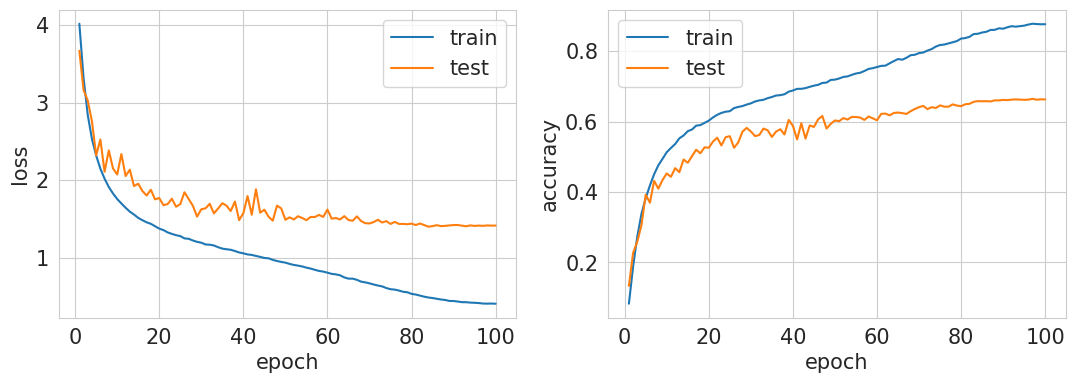

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    student, optimizer, scheduler, criterion,
    train_loader, test_loader, num_epochs
)

In [ ]:
test_loss, test_accuracy = validation_epoch(student, criterion, test_loader, tqdm_desc='Validating')
print(f'ResNet-20: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-20: test loss = 1.414, test acc = 66.26%


## Knowledge Distillation

In [ ]:
def distill_training_epoch(student, teacher, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    student.train()
    device = next(student.parameters()).device

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        student_logits = student(images)
        with torch.no_grad():
            teacher_logits = teacher(images)

        loss = criterion(student_logits, teacher_logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (student_logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def distill_validation_epoch(student, teacher, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    student.eval()
    device = next(student.parameters()).device
    loader = tqdm(test_loader, desc=tqdm_desc) if tqdm_desc is not None else test_loader
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        student_logits = student(images)
        teacher_logits = teacher(images)
        loss = criterion(student_logits, teacher_logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (student_logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def distill_train(student, teacher, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    teacher.eval()

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = distill_training_epoch(
            student, teacher, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = distill_validation_epoch(
            student, teacher, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temp=1, alpha=0.5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.temp = temp
        self.alpha = alpha

    def forward(self, student_logits, teacher_logits, labels):
        student_log_probs = torch.nn.functional.log_softmax(student_logits / self.temp, dim=-1)
        with torch.no_grad():
            teacher_probs = torch.nn.functional.softmax(teacher_logits / self.temp, dim=-1)

        distill_loss = -(teacher_probs * student_log_probs).sum(dim=-1).mean() * self.temp ** 2
        ce_loss = self.ce(student_logits, labels)
        return self.alpha * distill_loss + (1 - self.alpha) * ce_loss

In [ ]:
num_epochs = 100
student = resnet20(num_classes=100).to(device)
optimizer = torch.optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = DistillationLoss(temp=6, alpha=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

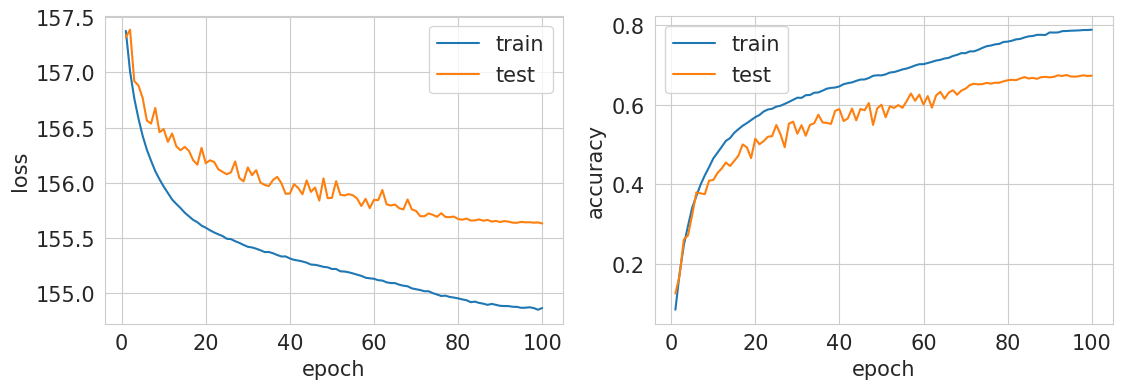

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = distill_train(
    student, teacher, optimizer, scheduler, criterion,
    train_loader, test_loader, num_epochs
)

In [ ]:
test_loss, test_accuracy = validation_epoch(student, nn.CrossEntropyLoss(), test_loader, tqdm_desc='Validating')
print(f'ResNet-20: test loss = {test_loss:.3f}, test acc = {100 * test_accuracy:.2f}%')

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

ResNet-20: test loss = 1.297, test acc = 67.30%
